In [4]:
path = ""


def mount():
    global path
    from google.colab import drive
    drive.mount('/content/drive')
    path = "/content/drive/MyDrive/Colab Notebooks/컴퓨터비전/TeamProject/"


def local():
    global path
    path = "./resources/"

In [5]:
local()

In [6]:
import scipy.io as io
import numpy as np

# load the data
data = io.loadmat(path + "face_landmark.mat")
images = data["images"]
landmarks = data["landmarks"]
print("im_shape:", images.shape)
print("landmarks_shape:", landmarks.shape)

im_shape: (2140, 96, 96)
landmarks_shape: (2140, 15, 2)


### (1) Dataset visualization:

* Describe your goal
* Visualize a few random images
* Also mark the corresponding keypoints/landmarks on each image

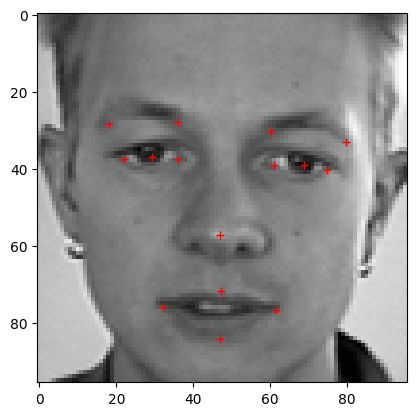

In [7]:
# visualize a random data
np.random.seed(101)
id = np.random.randint(len(images))
im = images[id]
keypoints = landmarks[id]

from matplotlib import pyplot as plt

plt.imshow(im, cmap="gray")
for point in keypoints:
    plt.plot(point[0], point[1], "r+")
plt.show()

### (2) Preprocessing (if any):

* E.g., normalization, reshaping, etc.

In [8]:
# randomly split into train (0.6), val(0.2), test(0.2)
np.random.seed(101)
n = landmarks.shape[0]
idx = np.random.permutation(n)
nTrain = int(0.6 * n)
nTrainVal = int((0.6 + 0.2) * n)
Xtrain, Ytrain = images[:nTrain], landmarks[:nTrain]
Xval, Yval = images[nTrain:nTrainVal], landmarks[nTrain:nTrainVal]
Xtest, Ytest = images[nTrainVal:], landmarks[nTrainVal:]

In [9]:
image_width = im.shape[1]

# Normalize pixel values to the range of [0, 1]
Xtrain = Xtrain / 255.0
Xval = Xval / 255.0
Xtest = Xtest / 255.0


### (3) Network structure:

* Describe and draw

In [10]:
import tensorflow as tf

regularizer = tf.keras.regularizers.L2(0.01)  # 람다가 0.01인 regularizer

x_in = x = tf.keras.Input(shape=[96, 96, 1])

x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same",
                           kernel_regularizer=regularizer)(x)

x = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(x)

x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same",
                           kernel_regularizer=regularizer)(x)

x = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(x)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same",
                           kernel_regularizer=regularizer)(x)

x = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(x)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same",
                           kernel_regularizer=regularizer)(x)

x = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(units=64, activation="relu", kernel_regularizer=regularizer)(x)

# x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(units=30, kernel_regularizer=regularizer)(x)

y = x = tf.keras.layers.Reshape((15, 2))(x)

model = tf.keras.Model(inputs=x_in, outputs=y)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496 

In [11]:
""" build the predictor function """


@tf.function
def predict(x):
    return model(x)

### (4) - Loss Functions:

* L2-loss
* L1-loss
* cosine-loss
  + X에 대한 코사인 유사도와 Y에 대한 코사인 유사도 따로 따로 확인 (X와 Y는 독립 변수이므로)
* Can you combine two loss functions to better the performance, 
  + e.g. L2-loss+ lamda*cosine-loss.


In [12]:
""" define loss function """


@tf.function
def loss_fn(y, y_true, loss='l2'):
    if loss == 'l1':
        return l1(y, y_true)
    elif loss == 'l2':
        return l2(y, y_true)
    elif loss == 'cos':
        return cos_error(y, y_true)
    else:
        raise "loss function error"


def l1(y, y_true):
    return tf.reduce_mean(tf.abs(y_true - y))


def l2(y, y_true):
    return tf.reduce_mean(tf.square(y_true - y))


def cos_error(y, y_true):
    return tf.reduce_mean(1 - tf.tensordot(y_true, y) / (tf.norm(y_true) * tf.norm(y)))

### (5) Results:

* Validation performance comparison:
  + For different loss functions
  + For different lamda values (if you combined loss-functions)
  + For different regularization
  + For dropout/ no-dropout

* Final performance on test set:
  * Present prediction error
  * And visualize a few good prediction, and a few bad prediction
* Present your discussion 


In [13]:
""" define the optimization step"""
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)


@tf.function
def optimize(x, y_true):
    with tf.GradientTape() as tape:
        y = predict(x)
        loss = loss_fn(y, y_true)
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [14]:
""" start training """
max_epochs = 1000
batch_size = 32

loss_history = []
val_loss_best = np.inf
for epoch in range(max_epochs):
    # get a minibatch
    idx = np.random.permutation(nTrain)
    batch_idx = idx[:batch_size]

    # optimize
    train_loss = optimize(Xtrain[batch_idx], Ytrain[batch_idx])
    train_loss = train_loss.numpy()

    # evaluate on val_set
    y = predict(Xval)
    val_loss = loss_fn(y, Yval).numpy()
    if val_loss < val_loss_best:
        val_loss_best = val_loss
        #model.save_weights('net_best')
    print(epoch, '.', train_loss, val_loss, val_loss_best)
    loss_history.append([train_loss, val_loss])


0 . 2561.8115 2632.5952 2632.5952
1 . 2633.7156 2626.3608 2626.3608
2 . 2579.7717 2614.3596 2614.3596
3 . 2557.527 2592.976 2592.976
4 . 2560.535 2556.993 2556.993
5 . 2526.777 2498.7024 2498.7024
6 . 2441.551 2409.5432 2409.5432
7 . 2419.6958 2277.7468 2277.7468
8 . 2305.6682 2095.5125 2095.5125
9 . 2113.9048 1869.4656 1869.4656
10 . 1870.7592 1641.5963 1641.5963
11 . 1621.071 1522.0745 1522.0745
12 . 1518.2394 1655.4694 1522.0745
13 . 1650.0961 1567.6846 1522.0745
14 . 1557.4329 1344.6128 1344.6128
15 . 1332.5922 1177.7908 1177.7908
16 . 1215.1516 1094.0461 1094.0461
17 . 1125.0535 1057.4108 1057.4108
18 . 1109.9325 1017.5019 1017.5019
19 . 1066.7644 949.26715 949.26715
20 . 949.6039 858.79175 858.79175
21 . 954.5025 758.54395 758.54395
22 . 801.8533 677.2807 677.2807
23 . 748.13074 633.5445 633.5445
24 . 690.1894 608.506 608.506
25 . 613.6672 587.96454 587.96454
26 . 631.45105 515.93146 515.93146
27 . 524.11847 416.45657 416.45657
28 . 450.08835 339.74222 339.74222
29 . 362.69446 29

In [19]:
val_p = model.predict(Xval)

mse = tf.reduce_mean(tf.square(val_p - Yval))

print("Mean Squared Error :", mse)

14/14 [==============================] - 0s 16ms/step
Mean Squared Error : tf.Tensor(13.152199, shape=(), dtype=float32)


In [20]:
mses = np.mean(np.mean(np.square(val_p - Yval), axis=1), axis=1)
mses.shape

(428,)

In [21]:
max_idx = np.argmax(mses);
print(max_idx, mses[max_idx])
min_idx = np.argmin(mses);
print(min_idx, mses[min_idx])

338 130.05948
0 1.4752518


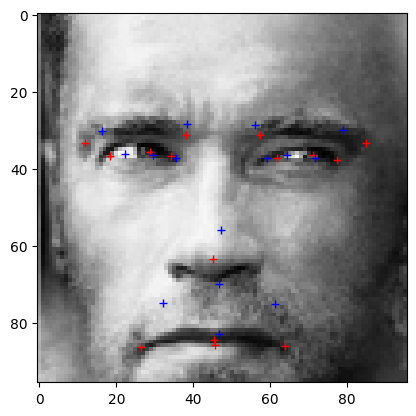

In [24]:
worst_img = Xtest[max_idx]
worst_ps = val_p[max_idx]
worst_ys = Ytest[max_idx]

plt.imshow(worst_img, cmap="gray")
for point in worst_ys:  # Red for label
    plt.plot(point[0], point[1], "r+")
for point in worst_ps:  # Blue for prediction
    plt.plot(point[0], point[1], "b+")
plt.show()

In [ ]:
# """ evalute on test test"""
# # load the best network
# #model.load_weights('net_best')

# # predict and evaluate
# p = model.predict(Xtest)

# mse = tf.reduce_mean(tf.square(p - Ytest))

# print("Mean Squared Error :", mse)